In [3]:
# true if working from tbi, false is working from home
tbi = False

if tbi:
    base_folder = '/scr/aldea/kgutenbrunner/github/MA/'
else:
    base_folder = '/Users/katringutenbrunner/Desktop/MA/github/MA/'

## Mosquito Borne Flavi Virus Analysis

In [7]:
import os
import csv
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from Bio import AlignIO

In [8]:
# get all the stk files except YFV
stk_folder = os.path.join(base_folder, 'data/mbfv_stk/')
stk_files = [os.path.join(stk_folder, file) for file in os.listdir(stk_folder) if file.endswith('xrRNA1.stk') and 'YFV' not in file]

In [9]:
# get the seqeuences from each stk file
sequences = []
rfs = []
for stk_file in stk_files:
    align = AlignIO.read(stk_file, "stockholm")
    rfs.append(align.column_annotations['reference_annotation'])
    for record in align:
        sequences.append(str(record.seq))

In [10]:
# import data from length counting file
# left YVf out since it has a really big hl beta --> outlier
MBFV_count_file = os.path.join(base_folder, 'xrRNA_design/analysis_MBFV/data/MBFV_xrRNA1.txt')
df = pd.read_csv(MBFV_count_file, delimiter=",")


In [16]:
# clean up data
# stems are counting as base pairs not nts
df = df.drop(columns=['seq_ML', 'seq_PKA', 'seq_PKB'])
# add stem structure together for further analysis
df_nts = df.copy()
temp_df = df_nts.drop(columns='name').astype(int)
df_nts['alpha'] = temp_df['stemA']*2
df_nts['beta'] = temp_df['stemB']*2 + temp_df['hlB']
df_nts['gamma'] = temp_df['stemG']*2 + temp_df['hlG']
df_nts['stemG'] = temp_df['stemG']*2
df_nts['stemB'] = temp_df['stemB']*2
df_nts['stemA'] = temp_df['stemA']*2

df_nts['n_PK'] = temp_df['n_PK']*2
# df_merge = df_merge[['name', 'I', 'II', 'III', 'HL', 'sum']]
new_order = ['name', 'stemA', 'alpha', 'stemB', 'hlB', 'beta', 'stemG','hlG','gamma', 'n_PK','bPK','b_PK','a_PK', 'len']

# save the df as unique dataframe for later use
df_MBFV = df_nts[new_order]

## design Scaffold

In [11]:
df.describe()

,stemA,stemB,hlB,stemG,hlG,bPK,n_PK,b_PK,a_PK,len
count,20.0,20.000000,20.000000,20.00000,20.000000,20.000000,20.00000,20.000000,20.000000,20.00000
mean,5.0,2.950000,4.900000,5.40000,11.150000,1.900000,5.80000,2.600000,2.400000,56.95000
std,0.0,1.431782,1.372665,0.88258,2.277464,2.174009,1.67332,1.667018,1.500877,3.88621
min,5.0,1.000000,3.000000,4.00000,5.000000,0.000000,3.00000,0.000000,1.000000,50.00000
25%,5.0,2.000000,4.000000,5.00000,9.750000,0.000000,4.00000,1.750000,1.000000,54.75000
50%,5.0,3.000000,5.000000,5.00000,12.000000,2.000000,6.00000,3.000000,2.500000,57.00000
75%,5.0,4.000000,6.000000,6.00000,13.000000,3.000000,7.25000,3.000000,3.000000,60.00000
max,5.0,5.000000,7.000000,8.00000,15.000000,6.000000,8.00000,7.000000,5.000000,62.00000


In [12]:
# min max of the single structures
seq =           'NNNNNNNNNXXXXXNNNXXXXXXXXXNNNNNNXXXXXXXXXXNNNNXXXXNXXXXXXXXXNNNNNNNNNNNXXXXXXNNNNXXXX'
base =          '...(((((((((((.......)))))).((((((((....................))))))))..)))))..............'
pk1 =           '((..............................................................))...................'
pk2 =           '..........................................((((((((...........................))))))))'
#                   alpha|   steam beta               stem gamma               alpha
# limit HL gamma since it can now be longer than wanted --> can be 20 but maximum is 15

inserting the fixed sequences

In [13]:
df['seq_ML']

0     CCGCCGCKG
1     CCGCCGCUG
2     CCGCCGUCG
3     CCGCCGCUG
4     CCGCCGCUA
5     CCGCCGCWA
6     CCGCCGCUA
7     CCGCCGCUG
8     CCGCCGCUG
9     CCGCCGCUG
10    CCGCCGCUG
11    CCGCCGCUG
12    CCGCCGCUG
13    CCGCCGCUG
14    CCGCCGCUG
15    CCGCUACUG
16    CCGCCGCUG
17    CCGCCGCUG
18    CCGCCGCUG
19    CCGCCGCAG
Name: seq_ML, dtype: object

In [14]:
# inserting Multi loop and also stem alpha into scaffold 
#                *********                 ***                                  ********
seq =           'AGUCAGGCCXXXXXNNNXXXXXXXXXGCCNNNXXXXXXXXXXNNNNXXXXNXXXXXXXXXNNNGCUGCCUGXXXXXXNNNNXXXX'
base =          '...(((((((((((.......)))))).((((((((....................))))))))..)))))..............'
pk1 =           '((..............................................................))...................'
pk2 =           '..........................................((((((((...........................))))))))'

In [15]:
len('AGUCAGGCCGA--UGA------UCGCCACGCC---------GGUGAG--GAAA---GGUGUGCUGCCUG--------UUCGCCAC'.replace('-', ''))

55

## structure analysis

In [23]:
import matplotlib.pyplot as plt

# function for correlation analysis
def correlation_analysis(df, method = 'spearman', statistic_file = False, save_fig = False, labels = None, mask = True):
    stats_df = df.drop(columns='name').astype(int)
    
    #create some correlation analysis
    corr =  stats_df.corr(method=method, numeric_only=False)
    
    # Display the correlation matrix
    if mask:
        mask = np.zeros_like(corr, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
        corr[mask] = np.nan

    if statistic_file:
        corr.to_csv(statistic_file)
        
    plt.figure(figsize=(10, 10))
    plt.imshow(corr, cmap='coolwarm', interpolation='nearest', vmin=-1, vmax=1,)
    plt.colorbar(label=f'Correlation')
    plt.title(f'Correlation Heatmap by {method}')
    
    if labels:
        plt.xticks(np.arange(len(corr)), labels, rotation=45)
        plt.yticks(np.arange(len(corr)), labels)
    else:
        plt.xticks(np.arange(len(corr)), corr.columns, rotation=45)
        plt.yticks(np.arange(len(corr)), corr.columns)
        
    if save_fig:
        plt.savefig(save_fig)
    else:
        plt.show()
    return corr

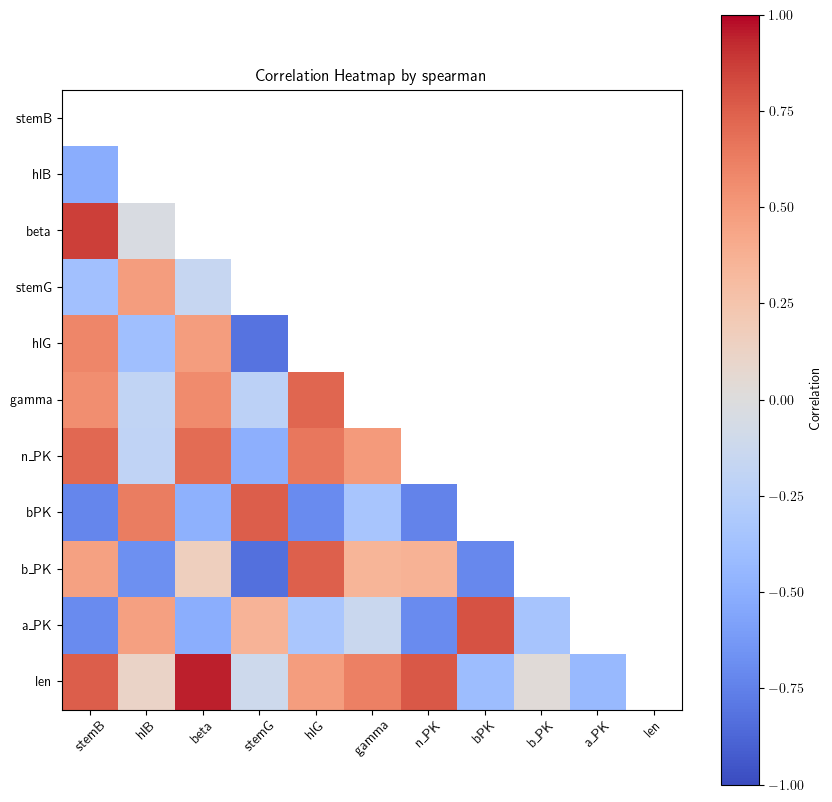

In [26]:
temp_df = df_MBFV.drop(columns=['stemA', 'alpha'])
correlation_analysis(temp_df, method="spearman", mask = True)
del temp_df

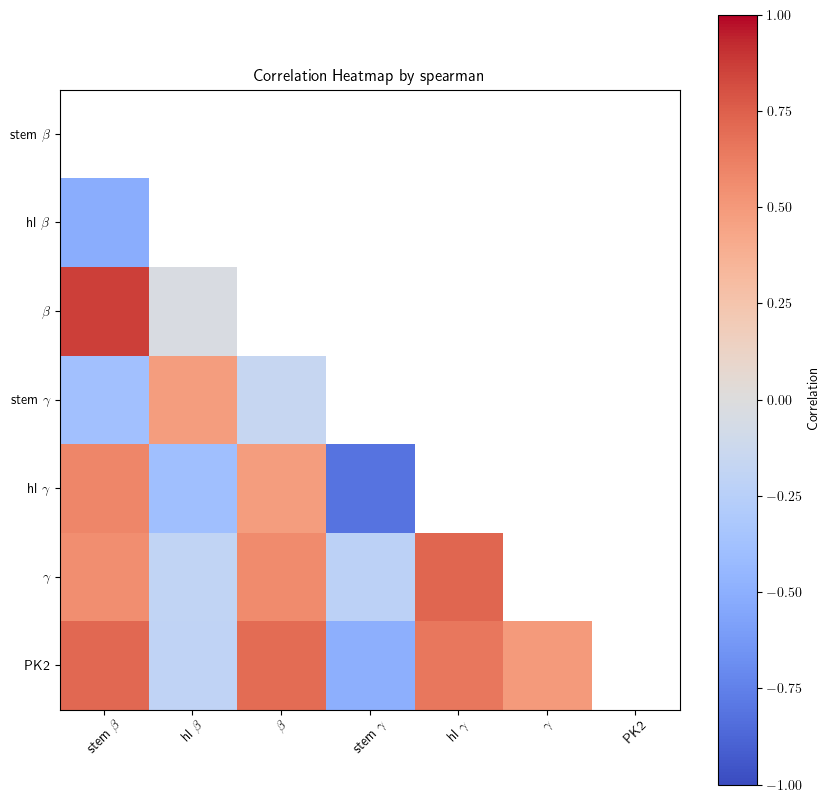

In [27]:
temp_df = df_MBFV.drop(columns=['stemA', 'alpha', 'bPK', 'a_PK', 'b_PK', 'len'])
labels = [r'stem $\beta$', r'hl $\beta$', r'$\beta$', r'stem $\gamma$', r'hl $\gamma$', r'$\gamma$', 'PK2']

correlation_analysis(temp_df, method="spearman", labels=labels, mask = True)
del temp_df

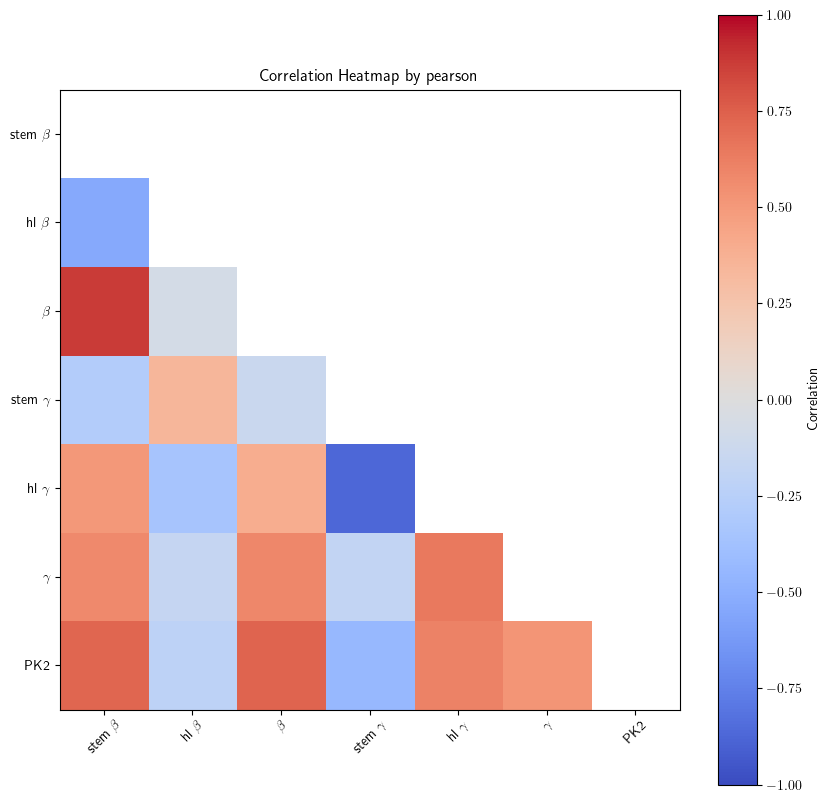

In [28]:
temp_df = df_MBFV.drop(columns=['stemA', 'alpha', 'bPK', 'a_PK', 'b_PK', 'len'])
labels = [r'stem $\beta$', r'hl $\beta$', r'$\beta$', r'stem $\gamma$', r'hl $\gamma$', r'$\gamma$', 'PK2']

correlation_analysis(temp_df, method="pearson", labels=labels, mask = True)
del temp_df

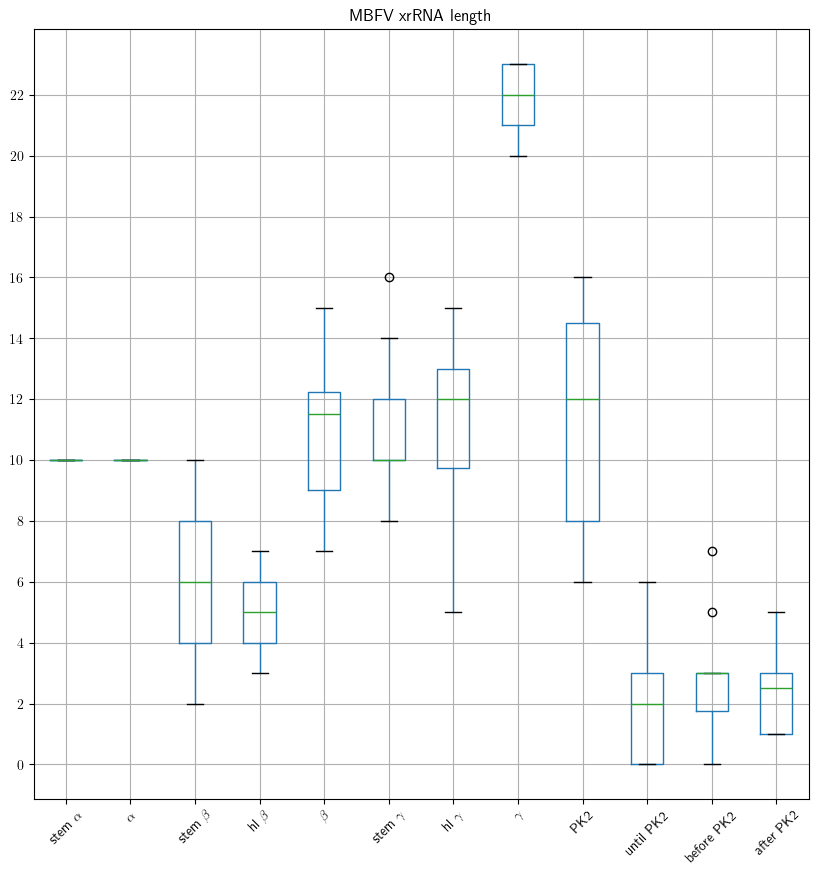

In [30]:
# create boxplot of different lengths
plt.rcParams['text.usetex'] = True

temp_df = df_MBFV.drop(columns=['name', 'len']).astype(int)
plt.figure(figsize=(10, 10))
temp_df.boxplot()
plt.title('MBFV xrRNA length')

labels = [r'stem $\alpha$', r'$\alpha$', r'stem $\beta$', r'hl $\beta$', r'$\beta$', r'stem $\gamma$', r'hl $\gamma$', r'$\gamma$', 'PK2', 'until PK2', 'before PK2', 'after PK2']
plt.xticks(list(range(1, len(labels)+1)), labels, rotation=45)
plt.yticks(np.arange(0, 24, step=2))
plt.show()
#save_file = os.path.join(base_folder, 'thesis/images/MBFV_xrRNA_analysis_boxplot.png')
#plt.savefig(save_file)

In [31]:
temp_df.describe()

,stemA,alpha,stemB,hlB,beta,stemG,hlG,gamma,n_PK,bPK,b_PK,a_PK
count,20.0,20.0,20.000000,20.000000,20.000000,20.00000,20.000000,20.000000,20.00000,20.000000,20.000000,20.000000
mean,10.0,10.0,5.900000,4.900000,10.800000,10.80000,11.150000,21.950000,11.60000,1.900000,2.600000,2.400000
std,0.0,0.0,2.863564,1.372665,2.419221,1.76516,2.277464,1.145931,3.34664,2.174009,1.667018,1.500877
min,10.0,10.0,2.000000,3.000000,7.000000,8.00000,5.000000,20.000000,6.00000,0.000000,0.000000,1.000000
25%,10.0,10.0,4.000000,4.000000,9.000000,10.00000,9.750000,21.000000,8.00000,0.000000,1.750000,1.000000
50%,10.0,10.0,6.000000,5.000000,11.500000,10.00000,12.000000,22.000000,12.00000,2.000000,3.000000,2.500000
75%,10.0,10.0,8.000000,6.000000,12.250000,12.00000,13.000000,23.000000,14.50000,3.000000,3.000000,3.000000
max,10.0,10.0,10.000000,7.000000,15.000000,16.00000,15.000000,23.000000,16.00000,6.000000,7.000000,5.000000


## length distribution

Text(0, 0.5, 'frequency')

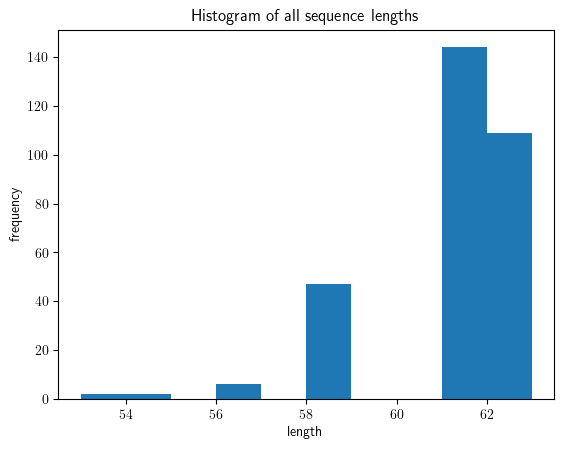

In [32]:
sequence_lengths =[len(seq) for seq in sequences]
plt.hist(sequence_lengths)
plt.title('Histogram of all sequence lengths')
plt.xlabel('length')
plt.ylabel('frequency')

In [33]:
import numpy as np
print(np.min(sequence_lengths))
print(np.max(sequence_lengths))
np.mean(sequence_lengths)

53
63


60.73870967741936

Text(0, 0.5, 'frequency')

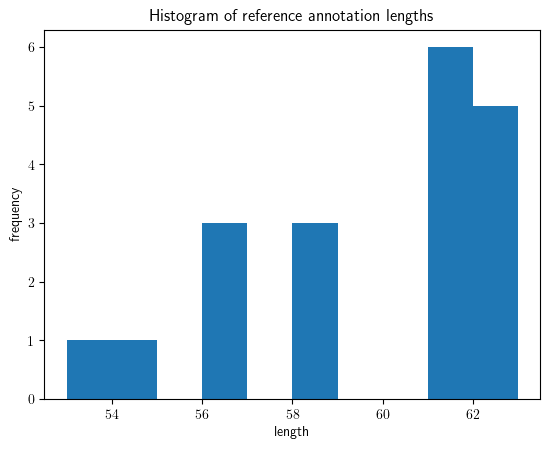

In [34]:
sequence_lengths =[len(seq) for seq in rfs]
plt.hist(sequence_lengths)
plt.title('Histogram of reference annotation lengths')
plt.xlabel('length')
plt.ylabel('frequency')

In [35]:
import RNA

In [36]:
mfes = []
for sequence in sequences:
    fc = RNA.fold_compound(sequence)
    fc.pf()
    (ss, mfe) = fc.mfe()
    mfes.append(mfe)
mfes = np.array(mfes)

In [37]:
print(np.min(mfes))
print(np.max(mfes))
np.mean(mfes)

-25.399999618530273
-7.400000095367432


-17.29193548848552

Text(0, 0.5, 'frequency')

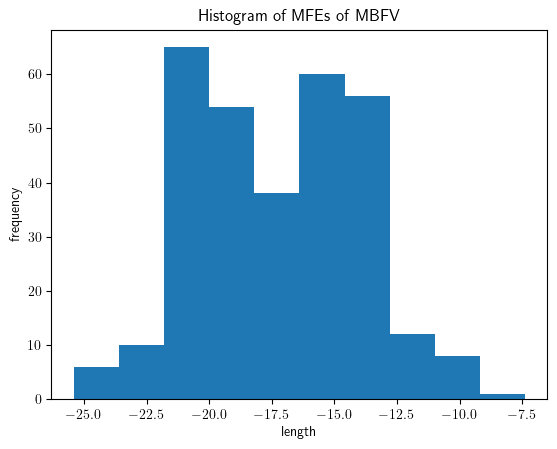

In [38]:
plt.hist(mfes)
plt.title('Histogram of MFEs of MBFV')
plt.xlabel('length')
plt.ylabel('frequency')

## Design MFES

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [16]:
design_csv = '/scr/aldea/kgutenbrunner/working/simRNA/MBFV_design/protocol_simRNA_MBFV.txt'

In [27]:
designs = pd.read_csv(design_csv, delimiter=';')

In [33]:
designs

,id,folder_name,seq,date,note
0,0,05_29,AGUCAGGCCCGAC-UUCUCU--GUCGGCCACGAUC-U--------G...,29.05.2024,'first try with MBFV design'
1,2,06_03,UGUCAGCCCCG--GACAA----CGGACACCCC--GACACC-AAA--...,03.06.2024,'MBFV testing with denis iupac - middle beta s...
2,3,06_04,UGUCAGCCCC---GAAAAA----GGACACCC---AUU----AGA--...,04.06.2024,'MBFV testing with denis iupac - short beta st...
3,1,06_05,UGUCAGGCCCGC-UUCAAU--GCGGACACC----C------UAAA-...,05.06.2024,'MBFV testing - long beta stem (4)'
4,4,06_12,UUCGCCGCCC---GAUGCUA---GGAGGGGUGCGGUUCGU-AUA--...,12.06.2024,'MBFV without any constraints only'
5,5,06_13,UUUGGGGCGCGACAACUUGAGUCGCCGAUCCUC-ACUCA--AAAA-...,13.06.2024,'MBFV without any constraints except the base ...
6,6,06_14,UUUGCGCCGCUCCGACA---GGAGCCGAGUC---AC-----UGA--...,14.06.2024,'MBFV without any constraints except the base ...
7,7,06_15,UGUCAGGCCCUGGGCUCA--CCAGGACACGG---GACA---AGA--...,15.06.2024,'MBFV with iupac constraints except no conserv...
8,8,06_16,UUCGCGCCGGGC-UGUU----GCCCAGGAGCC--AGA----AGG--...,16.06.2024,'MBFV with no iupac constraints except no cons...
9,9,06_17,AGUCAGGC-----------------CCACGUC---------ACCC-...,17.06.2024,'MBFV without beta stem and normal iupac const...


In [38]:
design_mfes = []
for seq in designs['seq']:
    seq = seq.replace('-', '')
    fc = RNA.fold_compound(seq)
    fc.pf()
    (ss, mfe) = fc.mfe()
    design_mfes.append(mfe)
design_mfes = np.array(design_mfes)

In [39]:
print(np.min(design_mfes))
print(np.max(design_mfes))
np.mean(design_mfes)

-27.899999618530273
-15.699999809265137


-22.337500035762787

Text(0, 0.5, 'frequency')

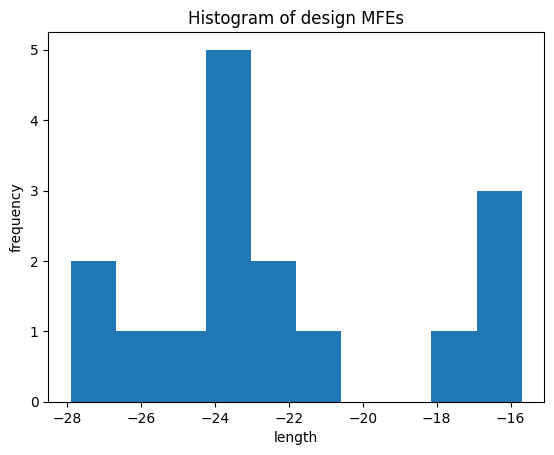

In [41]:
plt.hist(design_mfes)
plt.title('Histogram of design MFEs')
plt.xlabel('length')
plt.ylabel('frequency')

## calculate relations

In [40]:
df_MBFV

,name,stemA,alpha,stemB,hlB,beta,stemG,hlG,gamma,n_PK,bPK,b_PK,a_PK,len
0,AROAVG,10,10,4,4,8,10,12,22,12,2,3,3,54
1,BAGV,10,10,10,5,15,10,12,22,16,0,3,1,62
2,BANV,10,10,4,5,9,14,9,23,10,3,1,3,56
3,DENV1,10,10,2,7,9,12,9,21,8,6,0,5,56
4,DENV2,10,10,2,7,9,12,9,21,8,6,0,5,56
5,DENV3,10,10,2,7,9,12,9,21,6,6,1,5,55
6,DENV4,10,10,4,4,8,10,10,20,8,2,3,3,50
7,JEV,10,10,8,4,12,10,13,23,14,0,3,1,60
8,KOKV,10,10,4,4,8,10,10,20,12,0,3,1,51
9,KOUV,10,10,6,6,12,10,13,23,12,3,3,4,60


In [52]:
relation_gamma = []
for i in range(len(df_MBFV)):
    hl_gamma = df_MBFV.iloc[i]['hlG']
    stem_gamma = df_MBFV.iloc[i]['stemG']
    relation_gamma.append(stem_gamma/hl_gamma)   
relation_gamma = np.array(relation_gamma) 

In [53]:
df_describe = pd.DataFrame(relation_gamma)
df_describe.describe()

,0
count,20.000000
mean,1.066426
std,0.564307
min,0.533333
25%,0.769231
50%,0.833333
75%,1.151515
max,3.200000
